In [1]:
import os
import sys
import math
import argparse
import numpy as np
import pandas as pd
from collections import defaultdict, Counter
from sklearn.decomposition import PCA
from typing import Dict, List, Tuple, Iterable, Union, Optional, Set, Sequence, Callable, DefaultDict, Any

# Keras imports
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LeakyReLU, PReLU, ELU, ThresholdedReLU, Lambda, Reshape, LayerNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras.layers import SpatialDropout1D, SpatialDropout2D, SpatialDropout3D, add, concatenate
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Activation, Flatten, LSTM, RepeatVector
from tensorflow.keras.layers import Conv1D, Conv2D, Conv3D, UpSampling1D, UpSampling2D, UpSampling3D, MaxPooling1D
from tensorflow.keras.layers import MaxPooling2D, MaxPooling3D, AveragePooling1D, AveragePooling2D, AveragePooling3D, Layer
from tensorflow.keras.layers import SeparableConv1D, SeparableConv2D, DepthwiseConv2D, Concatenate, Add
from tensorflow.keras.layers import GlobalAveragePooling1D, GlobalAveragePooling2D, GlobalAveragePooling3D


# ML4CVD Imports
from ml4cvd.TensorMap import TensorMap
from ml4cvd.arguments import parse_args
from ml4cvd.models import make_multimodal_multitask_model, train_model_from_generators, make_hidden_layer_model, _conv_layer_from_kind_and_dimension
from ml4cvd.tensor_generators import TensorGenerator, big_batch_from_minibatch_generator, test_train_valid_tensor_generators
from ml4cvd.recipes import plot_predictions, infer_hidden_layer_multimodal_multitask

# IPython imports
%matplotlib inline
import matplotlib.pyplot as plt


Tensor = tf.Tensor

ACTIVATION_CLASSES = {
    'leaky': LeakyReLU(),
    'prelu': PReLU(),
    'elu': ELU(),
    'thresh_relu': ThresholdedReLU,
}
ACTIVATION_FUNCTIONS = {
    'swish': tf.nn.swish,
    'gelu': tfa.activations.gelu,
    'lisht': tfa.activations.lisht,
    'mish': tfa.activations.mish,
}
NORMALIZATION_CLASSES = {
    'batch_norm': BatchNormalization,
    'layer_norm': LayerNormalization,
    'instance_norm': tfa.layers.InstanceNormalization,
    'poincare_norm': tfa.layers.PoincareNormalize,
}
CONV_REGULARIZATION_CLASSES = {
    # class name -> (dimension -> class)
    'spatial_dropout': {2: SpatialDropout1D, 3: SpatialDropout2D, 4: SpatialDropout3D},
    'dropout': defaultdict(lambda _: Dropout),
}
DENSE_REGULARIZATION_CLASSES = {
    'dropout': Dropout,  # TODO: add l1, l2
}

In [2]:

def _activation_layer(activation: str) -> Activation:
    return (
        ACTIVATION_CLASSES.get(activation, None)
        or Activation(ACTIVATION_FUNCTIONS.get(activation, None) or activation)
    )


def _normalization_layer(norm: str) -> Layer:
    if not norm:
        return lambda x: x
    return NORMALIZATION_CLASSES[norm]()


def _regularization_layer(dimension: int, regularization_type: str, rate: float):
    if not regularization_type:
        return lambda x: x
    if regularization_type in DENSE_REGULARIZATION_CLASSES:
        return DENSE_REGULARIZATION_CLASSES[regularization_type](rate)
    return CONV_REGULARIZATION_CLASSES[regularization_type][dimension](rate)


def _calc_start_shape(
        num_upsamples: int, output_shape: Tuple[int, ...], upsample_rates: Sequence[int], channels: int,
) -> Tuple[int, ...]:
    """
    Given the number of blocks in the decoder and the upsample rates, return required input shape to get to output shape
    """
    upsample_rates = list(upsample_rates) + [1] * len(output_shape)
    return tuple((shape // rate**num_upsamples for shape, rate in zip(output_shape[:-1], upsample_rates))) + (channels,)


class FlatToStructure:
    """Takes a flat input, applies a dense layer, then restructures to output_shape"""
    def __init__(
            self,
            output_shape: Tuple[int, ...],
            activation: str,
            normalization: str,
    ):
        self.input_shapes = output_shape
        self.dense = Dense(units=int(np.prod(output_shape)))
        self.activation = _activation_layer(activation)
        self.reshape = Reshape(output_shape)
        self.norm = _normalization_layer(normalization)

    def __call__(self, x: Tensor) -> Tensor:
        return self.reshape(self.norm(self.activation(self.dense(x))))


def _conv_layer_from_kind_and_dimension(
        dimension: int, conv_layer_type: str, conv_x: List[int], conv_y: List[int], conv_z: List[int],
) -> Tuple[Layer, List[Tuple[int, ...]]]:
    if dimension == 4 and conv_layer_type == 'conv':
        conv_layer = Conv3D
        kernel = zip(conv_x, conv_y, conv_z)
    elif dimension == 3 and conv_layer_type == 'conv':
        conv_layer = Conv2D
        kernel = zip(conv_x, conv_y)
    elif dimension == 2 and conv_layer_type == 'conv':
        conv_layer = Conv1D
        kernel = zip(conv_x)
    elif dimension == 3 and conv_layer_type == 'separable':
        conv_layer = SeparableConv2D
        kernel = zip(conv_x, conv_y)
    elif dimension == 2 and conv_layer_type == 'separable':
        conv_layer = SeparableConv1D
        kernel = zip(conv_x)
    elif dimension == 3 and conv_layer_type == 'depth':
        conv_layer = DepthwiseConv2D
        kernel = zip(conv_x, conv_y)
    else:
        raise ValueError(f'Unknown convolution type: {conv_layer_type} for dimension: {dimension}')
    return conv_layer, list(kernel)


def _upsampler(dimension, pool_x, pool_y, pool_z):
    if dimension == 4:
        return UpSampling3D(size=(pool_x, pool_y, pool_z))
    elif dimension == 3:
        return UpSampling2D(size=(pool_x, pool_y))
    elif dimension == 2:
        return UpSampling1D(size=pool_x)
    

    
def _one_by_n_kernel(dimension):
    return tuple([1] * (dimension - 1))


class DenseConvolutionalBlock:
    def __init__(
            self,
            *,
            dimension: int,
            block_size: int,
            conv_layer_type: str,
            filters: int,
            conv_x: List[int],
            conv_y: List[int],
            conv_z: List[int],
            activation: str,
            normalization: str,
            regularization: str,
            regularization_rate: float,
    ):
        conv_layer, kernels = _conv_layer_from_kind_and_dimension(dimension, conv_layer_type, conv_x, conv_y, conv_z)
        if isinstance(conv_layer, DepthwiseConv2D):
            self.conv_layers = [conv_layer(kernel_size=kernel, padding='same') for kernel in kernels]
        else:
            self.conv_layers = [conv_layer(filters=filters, kernel_size=kernel, padding='same') for kernel in kernels]
        self.activations = [_activation_layer(activation) for _ in range(block_size)]
        self.normalizations = [_normalization_layer(normalization) for _ in range(block_size)]
        self.regularizations = [_regularization_layer(dimension, regularization, regularization_rate) for _ in range(block_size)]
        print(f'Dense Block Convolutional Layers (num_filters, kernel_size): {list(zip([filters]*len(kernels), kernels))}')

    def __call__(self, x: Tensor) -> Tensor:
        dense_connections = [x]
        for i, (convolve, activate, normalize, regularize) in enumerate(
            zip(
                    self.conv_layers, self.activations, self.normalizations, self.regularizations,
            ),
        ):
            x = normalize(regularize(activate(convolve(x))))
            if i < len(self.conv_layers) - 1:  # output of block does not get concatenated to
                dense_connections.append(x)
                x = Concatenate()(dense_connections[:])  # [:] is necessary because of tf weirdness
        return x

    
class ConvDecoder2:
    def __init__(
            self,
            *,
            tensor_map_out: TensorMap,
            filters_per_dense_block: List[int],
            conv_layer_type: str,
            conv_x: List[int],
            conv_y: List[int],
            conv_z: List[int],
            block_size: int,
            activation: str,
            normalization: str,
            regularization: str,
            regularization_rate: float,
            upsample_x: int,
            upsample_y: int,
            upsample_z: int,
    ):
        dimension = tensor_map_out.axes()
        self.dense_blocks = [
            DenseConvolutionalBlock(
                dimension=tensor_map_out.axes(), conv_layer_type=conv_layer_type, filters=filters, conv_x=[x]*block_size,
                conv_y=[y]*block_size, conv_z=[z]*block_size, block_size=block_size, activation=activation, normalization=normalization,
                regularization=regularization, regularization_rate=regularization_rate,
            )
            for filters, x, y, z in zip(filters_per_dense_block, conv_x, conv_y, conv_z)
        ]
        conv_layer, _ = _conv_layer_from_kind_and_dimension(dimension, 'conv', conv_x, conv_y, conv_z)
        self.conv_label = conv_layer(tensor_map_out.shape[-1], _one_by_n_kernel(dimension), activation=tensor_map_out.activation, name=tensor_map_out.output_name())
        self.upsamples = [_upsampler(dimension, upsample_x, upsample_y, upsample_z) for _ in range(len(filters_per_dense_block) + 1)]
        print(f'Decode has: {list(enumerate(zip(self.dense_blocks, self.upsamples)))}')
    def __call__(self, x: Tensor) -> Tensor:
        for i, (dense_block, upsample) in enumerate(zip(self.dense_blocks, self.upsamples)):
            
            x = upsample(x)
            x = dense_block(x)
        return self.conv_label(x)
    
    

In [4]:
from tensorflow.keras.layers import Layer
from tensorflow import acos

def l2_norm(x, axis=None):
    """
    takes an input tensor and returns the l2 norm along specified axis
    """

    square_sum = K.sum(K.square(x), axis=axis, keepdims=True)
    norm = K.sqrt(K.maximum(square_sum, K.epsilon()))

    return norm

def pairwise_cosine_difference(t1, t2):
    """
    A [batch x n x d] tensor of n rows with d dimensions
    B [batch x m x d] tensor of n rows with d dimensions

    returns:
    D [batch x n x m] tensor of cosine similarity scores between each point i<n, j<m
    """
    t1_norm = t1 / l2_norm(t1, axis=-1)
    t2_norm = t2 / l2_norm(t2, axis=-1)
    dot = K.clip(K.batch_dot(t1, t2), -1, 1)
    return acos(dot)

class CosineLossLayer(Layer):
    """Layer that creates an Cosine loss."""
    def __init__(self, weight):
        super(CosineLossLayer, self).__init__()
        self.weight = weight
    def get_config(self):
        config = super().get_config().copy()
        config.update({'weight': self.weight})
        return config
    def call(self, inputs):
        # We use `add_loss` to create a regularization loss
        # that depends on the inputs.
        self.add_loss(self.weight * pairwise_cosine_difference(inputs[0], inputs[1]))
        return inputs

class L2LossLayer(Layer):
    """Layer that creates an L2 loss."""
    def __init__(self, weight):
        super(L2LossLayer, self).__init__()
        self.weight = weight
        
    def get_config(self):
        config = super().get_config().copy()
        config.update({'weight': self.weight})
        return config
    
    def call(self, inputs):
        self.add_loss(self.weight * tf.reduce_sum(tf.square(inputs[0] - inputs[1])))
        return inputs

In [5]:
def make_paired_autoencoder_model(
    pairs: List[Tuple[TensorMap, TensorMap]],
    pair_loss = 'cosine',
    **kwargs
) -> Model:
    inputs = {tm: Input(shape=tm.shape, name=tm.input_name()) for tm in args.tensor_maps_in}
    original_outputs = {tm:1 for tm in args.tensor_maps_out}
    multimodal_activations = []
    desired_distance_tm = []
    my_metrics = {}
    outputs = []
    losses = []
    for left, right in pairs:
        args.tensor_maps_in = [left]
        left_model = make_multimodal_multitask_model(**args.__dict__)
        encode_left = make_hidden_layer_model(left_model, [left], args.hidden_layer)
        h_left = encode_left(inputs[left])
        
        args.tensor_maps_in = [right]
        right_model = make_multimodal_multitask_model(**args.__dict__)     
        encode_right = make_hidden_layer_model(right_model, [right], args.hidden_layer)
        h_right = encode_right(inputs[right])        
        
        if pair_loss == 'cosine':
            loss_layer = CosineLossLayer(100.0)
        elif pair_loss == 'euclid':
            loss_layer = L2LossLayer(100.0)
        
        paired_embeddings = loss_layer([h_left, h_right])
        multimodal_activations.extend(paired_embeddings)
        
    multimodal_activation = Concatenate()(multimodal_activations)
    
    pre_decoder_shapes: Dict[TensorMap, Optional[Tuple[int, ...]]] = {}
    for tm in args.tensor_maps_out:
        shape = _calc_start_shape(num_upsamples=len(args.dense_blocks), output_shape=tm.shape, 
                                  upsample_rates=[args.pool_x, args.pool_y, args.pool_z], 
                                  channels=args.dense_blocks[-1])    
        
        restructure = FlatToStructure(output_shape=shape, activation=args.activation, 
                                      normalization=args.dense_normalize)
        
        decode = ConvDecoder2(
            tensor_map_out=tm,
            filters_per_dense_block=args.dense_blocks[::-1],
            conv_layer_type=args.conv_type,
            conv_x=args.conv_x,
            conv_y=args.conv_y,
            conv_z=args.conv_z,
            block_size=args.block_size,
            activation=args.activation,
            normalization=args.conv_normalize,
            regularization=args.conv_regularize,
            regularization_rate=args.conv_regularize_rate,
            upsample_x=args.pool_x,
            upsample_y=args.pool_y,
            upsample_z=args.pool_z,
        )
        
        outputs.append(decode(restructure(multimodal_activation)))
        losses.append(tm.loss)

    args.tensor_maps_out =  list(original_outputs.keys()) + desired_distance_tm
    args.tensor_maps_in = list(inputs.keys())
    
    opt = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    #outputs.reverse()  # Make paired loss last
    #losses.reverse()
    m = Model(inputs=list(inputs.values()), outputs=outputs)
    m.compile(optimizer=opt, loss=losses)
    m.summary()
    
    if kwargs['model_layers'] is not None:
        m.load_weights(kwargs['model_layers'], by_name=True)
        print(f"Loaded model weights from:{kwargs['model_layers']}")
        
    return m

In [ ]:
sys.argv = ['train', 
            '--tensors', '/mnt/disks/segmented-sax-lax/2020-07-07/', 
            '--input_tensors', 'lax_2ch_diastole_slice0_3d', 'lax_3ch_diastole_slice0_3d', 
            '--output_tensors', 'lax_2ch_diastole_slice0_3d', 'lax_3ch_diastole_slice0_3d',
            '--activation', 'swish',
            '--conv_layers', '32',
            '--conv_x', '3', '3', '3',
            '--conv_y', '3', '3', '3', 
            '--conv_z', '3', '3', '3', 
            '--dense_blocks', '32', '32', '32',
            '--block_size', '3',
            '--dense_layers', '512',
            '--pool_x', '2',
            '--pool_y', '2',
            '--batch_size', '1',
            '--patience', '32',
            '--epochs', '248',
            '--learning_rate', '0.001',
            '--training_steps', '256',
            '--validation_steps', '30',
            '--test_steps', '2',
            '--num_workers', '4',
            '--inspect_model',
            '--tensormap_prefix', 'ml4cvd.tensormap.ukb.mri',
            '--id', 'lax_2ch_3ch_diastole_pair_cosine_loss']
args = parse_args()
pairs = [(args.tensor_maps_in[0], args.tensor_maps_in[1])]
overparameterized_model = make_paired_autoencoder_model(pairs, pair_loss='cosine', **args.__dict__)
generate_train, generate_valid, generate_test = test_train_valid_tensor_generators(**args.__dict__)
train_model_from_generators(
        overparameterized_model, generate_train, generate_valid, args.training_steps, args.validation_steps, args.batch_size,
        args.epochs, args.patience, args.output_folder, args.id, args.inspect_model, args.inspect_show_labels,
)

2020-08-21 07:52:54,175 - logger:25 - INFO - Logging configuration was loaded. Log messages can be found at ./recipes_output/lax_2ch_3ch_diastole_pair_cosine_loss/log_2020-08-21_07-52_0.log.
2020-08-21 07:52:54,349 - arguments:414 - INFO - Command Line was: 
./scripts/tf.sh train --tensors /mnt/disks/segmented-sax-lax/2020-07-07/ --input_tensors lax_2ch_diastole_slice0_3d lax_3ch_diastole_slice0_3d --output_tensors lax_2ch_diastole_slice0_3d lax_3ch_diastole_slice0_3d --activation swish --conv_layers 32 --conv_x 3 3 3 --conv_y 3 3 3 --conv_z 3 3 3 --dense_blocks 32 32 32 --block_size 3 --dense_layers 512 --pool_x 2 --pool_y 2 --batch_size 1 --patience 32 --epochs 248 --learning_rate 0.001 --training_steps 256 --validation_steps 30 --test_steps 2 --num_workers 4 --inspect_model --tensormap_prefix ml4cvd.tensormap.ukb.mri --id lax_2ch_3ch_diastole_pair_cosine_loss

2020-08-21 07:52:54,365 - models:801 - WARNING - Number of x dimensions for convolutional kernel sizes (3) do not match numb

2020-08-21 07:52:56,920 - models:801 - WARNING - Number of x dimensions for convolutional kernel sizes (3) do not match number of convolutional layers/blocks (4), matching values to fit 4 convolutional layers/blocks.
2020-08-21 07:52:56,921 - models:801 - WARNING - Number of y dimensions for convolutional kernel sizes (3) do not match number of convolutional layers/blocks (4), matching values to fit 4 convolutional layers/blocks.
2020-08-21 07:52:56,924 - models:801 - WARNING - Number of z dimensions for convolutional kernel sizes (3) do not match number of convolutional layers/blocks (4), matching values to fit 4 convolutional layers/blocks.
2020-08-21 07:52:56,927 - models:379 - INFO - Residual Block Convolutional Layers (num_filters, kernel_size): [(32, (3, 3))]
2020-08-21 07:52:56,935 - models:414 - INFO - Dense Block Convolutional Layers (num_filters, kernel_size): [(32, (3, 3)), (32, (3, 3)), (32, (3, 3))]
2020-08-21 07:52:56,940 - models:414 - INFO - Dense Block Convolutional La

Dense Block Convolutional Layers (num_filters, kernel_size): [(32, (3, 3)), (32, (3, 3)), (32, (3, 3))]
Dense Block Convolutional Layers (num_filters, kernel_size): [(32, (3, 3)), (32, (3, 3)), (32, (3, 3))]
Dense Block Convolutional Layers (num_filters, kernel_size): [(32, (3, 3)), (32, (3, 3)), (32, (3, 3))]
Decode has: [(0, (<__main__.DenseConvolutionalBlock object at 0x7fd0e85fae80>, <tensorflow.python.keras.layers.convolutional.UpSampling2D object at 0x7fd0e8619b70>)), (1, (<__main__.DenseConvolutionalBlock object at 0x7fd0e8560a58>, <tensorflow.python.keras.layers.convolutional.UpSampling2D object at 0x7fd0e86194e0>)), (2, (<__main__.DenseConvolutionalBlock object at 0x7fd0e8621b00>, <tensorflow.python.keras.layers.convolutional.UpSampling2D object at 0x7fd0e8619da0>))]
Dense Block Convolutional Layers (num_filters, kernel_size): [(32, (3, 3)), (32, (3, 3)), (32, (3, 3))]
Dense Block Convolutional Layers (num_filters, kernel_size): [(32, (3, 3)), (32, (3, 3)), (32, (3, 3))]
Dense

2020-08-21 07:53:02,524 - tensor_generators:661 - INFO - Found 31871 train, 9242 validation, and 4569 testing tensors at: /mnt/disks/segmented-sax-lax/2020-07-07/
2020-08-21 07:53:02,894 - models:1316 - INFO - Saving architecture diagram to:./recipes_output/lax_2ch_3ch_diastole_pair_cosine_loss/architecture_graph_lax_2ch_3ch_diastole_pair_cosine_loss.png
2020-08-21 07:53:05,039 - tensor_generators:151 - INFO - Started 3 train workers with cache size 0.875GB.
2020-08-21 07:53:05,165 - tensor_generators:151 - INFO - Started 1 validation workers with cache size 0.875GB.
Train for 256 steps, validate for 1 steps
256/256 [==============================] - 24s 95ms/step - loss: 2.5509 - output_lax_3ch_diastole_slice0_3d_continuous_loss: 0.2416 - output_lax_2ch_diastole_slice0_3d_continuous_loss: 0.2902 - val_loss: 0.4430 - val_output_lax_3ch_diastole_slice0_3d_continuous_loss: 0.1869 - val_output_lax_2ch_diastole_slice0_3d_continuous_loss: 0.2561
2020-08-21 07:53:29,559 - models:1254 - INFO 

In [ ]:
sys.argv = ['train', 
            '--tensors', '/mnt/disks/segmented-sax-lax/2020-07-07/', 
            '--input_tensors', 'lax_2ch_diastole_slice0_3d', 'lax_3ch_diastole_slice0_3d', 
            '--output_tensors',  'lax_2ch_diastole_slice0_3d', 'lax_3ch_diastole_slice0_3d', 'LVM',
            '--activation', 'swish',
            '--conv_layers', '24',
            '--conv_x', '3', '3', '3',
            '--conv_y', '3', '3', '3',
            '--conv_z', '3', '3', '3',
            '--dense_blocks', '24',
            '--block_size', '4',
            '--dense_layers', '512',
            '--pool_x', '2',
            '--pool_y', '2',
            '--batch_size', '2',
            '--patience', '32',
            '--epochs', '292',
            '--learning_rate', '0.001',
            '--training_steps', '256',
            '--validation_steps', '30',
            '--test_steps', '2',
            '--num_workers', '4',
            '--hidden_layer', 'concatenate_12',
            '--model_file', './recipes_output/lax_2ch_3ch_diastole_paired_autoencoder_swish/lax_2ch_3ch_diastole_paired_autoencoder_swish.h5',
            '--tensormap_prefix', 'ml4cvd.tensormap.ukb.mri',
            '--id', 'lax_2ch_3ch_diastole_paired_autoencoder_swish']
args = parse_args()
#plot_predictions(args)
infer_hidden_layer_multimodal_multitask(args)

2020-08-19 09:47:08,241 - logger:25 - INFO - Logging configuration was loaded. Log messages can be found at ./recipes_output/lax_2ch_3ch_diastole_paired_autoencoder_swish/log_2020-08-19_09-47_0.log.
2020-08-19 09:47:08,370 - arguments:414 - INFO - Command Line was: 
./scripts/tf.sh train --tensors /mnt/disks/segmented-sax-lax/2020-07-07/ --input_tensors lax_2ch_diastole_slice0_3d lax_3ch_diastole_slice0_3d --output_tensors lax_2ch_diastole_slice0_3d lax_3ch_diastole_slice0_3d LVM --activation swish --conv_layers 24 --conv_x 3 3 3 --conv_y 3 3 3 --conv_z 3 3 3 --dense_blocks 24 --block_size 4 --dense_layers 512 --pool_x 2 --pool_y 2 --batch_size 2 --patience 32 --epochs 292 --learning_rate 0.001 --training_steps 256 --validation_steps 30 --test_steps 2 --num_workers 4 --hidden_layer concatenate_12 --model_file ./recipes_output/lax_2ch_3ch_diastole_paired_autoencoder_swish/lax_2ch_3ch_diastole_paired_autoencoder_swish.h5 --tensormap_prefix ml4cvd.tensormap.ukb.mri --id lax_2ch_3ch_diasto

2020-08-19 09:47:14,164 - recipes:292 - INFO - Dummy output shape is: (1, 512) latent dimensions: 512
2020-08-19 10:08:40,074 - recipes:316 - INFO - Wrote:500 rows of latent space inference.  Last tensor:/mnt/disks/segmented-sax-lax/2020-07-07/1686043.hd5
2020-08-19 10:27:50,032 - recipes:316 - INFO - Wrote:1000 rows of latent space inference.  Last tensor:/mnt/disks/segmented-sax-lax/2020-07-07/2253565.hd5
2020-08-19 10:45:05,420 - recipes:316 - INFO - Wrote:1500 rows of latent space inference.  Last tensor:/mnt/disks/segmented-sax-lax/2020-07-07/2755254.hd5
2020-08-19 11:02:25,288 - recipes:316 - INFO - Wrote:2000 rows of latent space inference.  Last tensor:/mnt/disks/segmented-sax-lax/2020-07-07/3305476.hd5
2020-08-19 11:21:18,589 - recipes:316 - INFO - Wrote:2500 rows of latent space inference.  Last tensor:/mnt/disks/segmented-sax-lax/2020-07-07/3864291.hd5
2020-08-19 11:39:02,405 - recipes:316 - INFO - Wrote:3000 rows of latent space inference.  Last tensor:/mnt/disks/segmented-

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4452 entries, 0 to 4451
Columns: 550 entries, 21003_Age-when-attended-assessment-centre_2_0 to latent_511
dtypes: float64(547), int64(2), object(1)
memory usage: 18.7+ MB


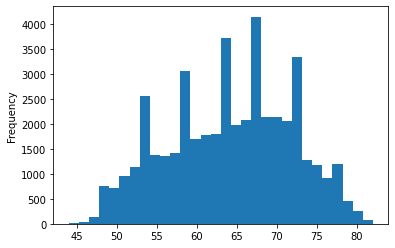

In [4]:
hidden_inference = './recipes_output/lax_2ch_3ch_diastole_paired_autoencoder_swish/hidden_inference_lax_2ch_3ch_diastole_paired_autoencoder_swish.tsv'
df = pd.read_csv('/home/sam/ml/trained_models/lax_4ch_diastole_autoencode_leaky_converge/tensors_all_union.csv')
df['21003_Age-when-attended-assessment-centre_2_0'].plot.hist(bins=30)

df2 = pd.read_csv(hidden_inference, sep='\t')
df['fpath'] = pd.to_numeric(df['fpath'], errors='coerce')
df2['sample_id'] = pd.to_numeric(df2['sample_id'], errors='coerce')
#df.info()
latent_df = pd.merge(df, df2, left_on='fpath', right_on='sample_id', how='inner')
# #latent_df.info()
# df3 = pd.read_csv('/home/sam/tsvs/ttn_disease.tsv', sep='\t')
# df4 = pd.read_csv('/home/sam/csvs/has_exome.csv')
# latent_df = pd.merge(df3, latent_df, left_on='sample_id', right_on='sample_id', how='right')
# 
# print(latent_df['has_ttntv'].value_counts())
latent_df.info()

In [5]:
def pca_on_matrix(matrix, pca_components):
    pca = PCA()
    pca.fit(matrix)
    print(f'PCA explains {100*np.sum(pca.explained_variance_ratio_[:pca_components]):0.1f}% of variance with {pca_components} top PCA components.')
    matrix_reduced = pca.transform(matrix)[:, :pca_components]
    print(f'PCA reduces matrix shape:{matrix_reduced.shape} from matrix shape: {matrix.shape}')
    plot_scree(pca_components, 100*pca.explained_variance_ratio_)
    return pca, matrix_reduced

def plot_scree(pca_components, percent_explained):
    _ = plt.figure(figsize=(6, 4))
    plt.plot(range(len(percent_explained)), percent_explained, 'g.-', linewidth=1)
    plt.axvline(x=pca_components, c='r', linewidth=3)
    label = f'{np.sum(percent_explained[:pca_components]):0.1f}% of variance explained by top {pca_components} of {len(percent_explained)} components'
    plt.text(pca_components+0.02*len(percent_explained), percent_explained[1], label)
    plt.title('Scree Plot')
    plt.xlabel('Principal Components')
    plt.ylabel('% of Variance Explained by Each Component')
    figure_path = f'./results/pca_{pca_components}_of_{len(percent_explained)}_testimonials.png'
    if not os.path.exists(os.path.dirname(figure_path)):
        os.makedirs(os.path.dirname(figure_path))
    plt.savefig(figure_path)
    
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

def directions_in_latent_space(stratify_column, stratify_thresh, split_column, split_thresh, latent_cols, latent_df):
    hit = latent_df.loc[latent_df[stratify_column] >= stratify_thresh][latent_cols].to_numpy()
    miss = latent_df.loc[latent_df[stratify_column] < stratify_thresh][latent_cols].to_numpy()
    miss_mean_vector = np.mean(miss, axis=0)
    hit_mean_vector = np.mean(hit, axis=0)
    strat_vector = hit_mean_vector - miss_mean_vector
    
    hit1 = latent_df.loc[(latent_df[stratify_column] >= stratify_thresh) 
                        & (latent_df[split_column] >= split_thresh)][latent_cols].to_numpy()
    miss1 = latent_df.loc[(latent_df[stratify_column] < stratify_thresh) 
                        & (latent_df[split_column] >= split_thresh)][latent_cols].to_numpy()
    hit2 = latent_df.loc[(latent_df[stratify_column] >= stratify_thresh) 
                        & (latent_df[split_column] < split_thresh)][latent_cols].to_numpy()
    miss2 = latent_df.loc[(latent_df[stratify_column] < stratify_thresh) 
                        & (latent_df[split_column] < split_thresh)][latent_cols].to_numpy()
    miss_mean_vector1 = np.mean(miss1, axis=0)
    hit_mean_vector1 = np.mean(hit1, axis=0)
    angle1 = angle_between(miss_mean_vector1, hit_mean_vector1)
    miss_mean_vector2 = np.mean(miss2, axis=0)
    hit_mean_vector2 = np.mean(hit2, axis=0)
    angle2 = angle_between(miss_mean_vector2, hit_mean_vector2)
    h1_vector = hit_mean_vector1-miss_mean_vector1
    h2_vector = hit_mean_vector2-miss_mean_vector2
    angle3 = angle_between(h1_vector, h2_vector)
    angle4 = angle_between(strat_vector, h1_vector)
    angle5 = angle_between(strat_vector, h2_vector)
    print(f'\n Between {stratify_column}, and splits: {split_column}\n',
          f'Angles: {angle1:.4f}, {angle2:.4f} \n'
          f'stratify threshold: {stratify_thresh}, split thresh: {split_thresh}, \n'
          f'hit_mean_vector2 shape {miss_mean_vector1.shape}, miss1:{hit_mean_vector2.shape} \n'
          f'Hit1 shape {hit1.shape}, miss1:{miss1.shape} threshold:{stratify_thresh}\n'
          f'Hit2 shape {hit2.shape}, miss2:{miss2.shape}\n')

def stratify_latent_space(stratify_column, stratify_thresh, latent_cols, latent_df):
    hit = latent_df.loc[latent_df[stratify_column] >= stratify_thresh][latent_cols].to_numpy()
    miss = latent_df.loc[latent_df[stratify_column] < stratify_thresh][latent_cols].to_numpy()
    miss_mean_vector = np.mean(miss, axis=0)
    hit_mean_vector = np.mean(hit, axis=0)
    angle = angle_between(miss_mean_vector, hit_mean_vector)
    print(f'Angle between {stratify_column} and all others: {angle}, \n'
          f'Hit shape {hit.shape}, miss:{miss.shape} threshold:{stratify_thresh}\n'
          f'Distance: {np.linalg.norm(hit_mean_vector-miss_mean_vector):.3f}, Hit std {np.std(hit, axis=1).mean():.3f}, miss std:{np.std(miss, axis=1).mean():.3f}\n')
    
def plot_pcs(sides, color_key):
    f, axes = plt.subplots(sides, sides, figsize=(16, 16))
    for i, ax in enumerate(axes.ravel()):
        colors = latent_df[color_key].to_numpy()
        points = ax.scatter(matrix_reduce[:, i], matrix_reduce[:, i+1], c=colors)
        f.colorbar(points, ax=ax)
        



PCA explains 26.7% of variance with 10 top PCA components.
PCA reduces matrix shape:(4452, 10) from matrix shape: (4452, 256)
Angle between Sex_Female_0_0 and all others: 1.5106068356712392, 
Hit shape (2343, 256), miss:(2109, 256) threshold:1.0
Distance: 0.212, Hit std 0.049, miss std:0.048

Angle between atrial_fibrillation_or_flutter and all others: 0.885900336987916, 
Hit shape (211, 256), miss:(4241, 256) threshold:1.0
Distance: 0.106, Hit std 0.049, miss std:0.049

Angle between coronary_artery_disease and all others: 0.7992989466802541, 
Hit shape (181, 256), miss:(4271, 256) threshold:1.0
Distance: 0.097, Hit std 0.049, miss std:0.049

Angle between hypertension and all others: 0.7685297946495178, 
Hit shape (1598, 256), miss:(2854, 256) threshold:1.0
Distance: 0.090, Hit std 0.049, miss std:0.049

Angle between LVEF and all others: 0.9949099780827789, 
Hit shape (4369, 256), miss:(69, 256) threshold:45
Distance: 0.127, Hit std 0.049, miss std:0.049

Angle between LVM and all o

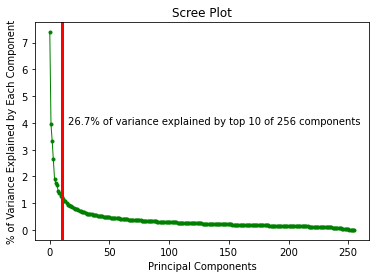

In [8]:
import matplotlib.pyplot as plt
latent_dimension = 256
latent_cols = [f'latent_{i}' for i in range(latent_dimension)]
pca, matrix_reduce = pca_on_matrix(df2[latent_cols].to_numpy(), 10)
for strat in ['Sex_Female_0_0', 'atrial_fibrillation_or_flutter', 
              'coronary_artery_disease', 'hypertension']:
    stratify_latent_space(strat, 1.0, latent_cols, latent_df)
strats = ['LVEF', 'LVM', 'LVEDV', 'sample_id',
              '21001_Body-mass-index-BMI_0_0', '21003_Age-when-attended-assessment-centre_2_0']
theshes = [45, 100, 150, 3500000, 27.5, 70]
for strat, thresh in zip(strats, theshes):
    stratify_latent_space(strat, thresh, latent_cols, latent_df)

PCA explains 28.8% of variance with 10 top PCA components.
PCA reduces matrix shape:(4452, 10) from matrix shape: (4452, 256)
Angle between Sex_Female_0_0 and all others: 1.522771585467638, 
Hit shape (2343, 256), miss:(2109, 256) threshold:1.0
Distance: 0.193, Hit std 0.049, miss std:0.047

Angle between atrial_fibrillation_or_flutter and all others: 1.0778784138521909, 
Hit shape (211, 256), miss:(4241, 256) threshold:1.0
Distance: 0.120, Hit std 0.048, miss std:0.048

Angle between coronary_artery_disease and all others: 0.9201441669143713, 
Hit shape (181, 256), miss:(4271, 256) threshold:1.0
Distance: 0.101, Hit std 0.048, miss std:0.048

Angle between hypertension and all others: 1.0197666360467195, 
Hit shape (1598, 256), miss:(2854, 256) threshold:1.0
Distance: 0.110, Hit std 0.049, miss std:0.048

Angle between LVEF and all others: 1.1922036138956966, 
Hit shape (4369, 256), miss:(69, 256) threshold:45
Distance: 0.137, Hit std 0.048, miss std:0.048

Angle between LVM and all o

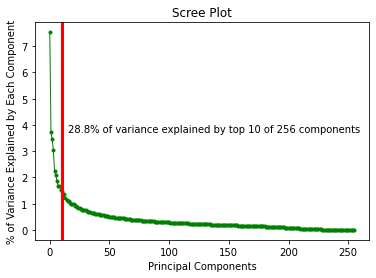

In [11]:
latent_dimension = 256
latent_cols = [f'latent_{256+i}' for i in range(latent_dimension)]
pca, matrix_reduce = pca_on_matrix(df2[latent_cols].to_numpy(), 10)
for strat in ['Sex_Female_0_0', 'atrial_fibrillation_or_flutter', 
              'coronary_artery_disease', 'hypertension']:
    stratify_latent_space(strat, 1.0, latent_cols, latent_df)
strats = ['LVEF', 'LVM', 'LVEDV', 'sample_id',
              '21001_Body-mass-index-BMI_0_0', '21003_Age-when-attended-assessment-centre_2_0']
theshes = [45, 100, 150, 1250000, 27.5, 70]
for strat, thresh in zip(strats, theshes):
    stratify_latent_space(strat, thresh, latent_cols, latent_df)

In [17]:
latent_dimension = 256
latent_cols = [f'latent_{i}' for i in range(latent_dimension)]
ch2_encode = df2[latent_cols].to_numpy()
latent_cols = [f'latent_{256+i}' for i in range(latent_dimension)]
ch3_encode = df2[latent_cols].to_numpy()
sqr_diff = (ch2_encode - ch3_encode) * (ch2_encode - ch3_encode)
print(sqr_diff.shape)
sum_sqr_diff = np.mean(np.sqrt(np.sum(sqr_diff, axis=-1)))
print(sum_sqr_diff)

(4452, 256)
0.9704160220738477


In [20]:
print(f'{ch2_encode[:5,:5]} \n{ch3_encode[:5,:5]}')

[[ 0.05233013 -0.00885089  0.00360998 -0.06839394 -0.02589234]
 [-0.02593587  0.00189394  0.06619974 -0.06018838 -0.0345119 ]
 [-0.02474542 -0.05122478 -0.05509999  0.00513599 -0.02294188]
 [ 0.03489961 -0.00412601  0.00678408  0.01040387  0.03033312]
 [-0.01927042  0.01537618  0.0755117  -0.02366783  0.07687532]] 
[[ 0.02240654 -0.05208255 -0.07111726 -0.06180399 -0.00224391]
 [ 0.08376911  0.04155055 -0.00522597  0.07499424  0.02577506]
 [ 0.0042082   0.09109999 -0.03343619  0.04051621  0.05887799]
 [ 0.08424532 -0.05437578 -0.04160891 -0.06672687  0.01862815]
 [ 0.02513371 -0.09732086 -0.0064374  -0.01407782  0.02086658]]


In [12]:
ch2_random = np.random.random((4452, 256))
ch3_random = np.random.random((4452, 256))
sqr_diff = (ch2_random - ch3_random) * (ch2_random - ch3_random)
print(sqr_diff.shape)
sum_sqr_diff = np.mean(np.sqrt(np.sum(sqr_diff, axis=-1)))
print(sum_sqr_diff)

(4452, 256)
6.527385999963261


In [16]:
latent_dimension = 256
latent_cols = [f'latent_{i}' for i in range(latent_dimension)]
ch2_encode = df2[latent_cols].to_numpy()
latent_cols = [f'latent_{98+i}' for i in range(latent_dimension)]
ch3_encode = df2[latent_cols].to_numpy()
sqr_diff = (ch2_encode - ch3_encode) * (ch2_encode - ch3_encode)
print(sqr_diff.shape)
sum_sqr_diff = np.mean(np.sqrt(np.sum(sqr_diff, axis=-1)))
print(sum_sqr_diff)

(4452, 256)
1.1068400191869823
